Minimum Operational Cost: 224.0 NOK
Total travel distance during the day: 64 km
Total travel distance during the night: 0 km
Total travel distance: 64 km
Recharge logs:
Excavator 3 starts charging at hour 11.00
Excavator 4 starts charging at hour 11.00
Excavator 2 starts charging at hour 12.00
Excavator 1 starts charging at hour 13.00
Excavator 4 starts charging at hour 13.00
Vehicle arrives at Charging site 2 at hour 13.40
Charging site battery 2 replaced at hour 13.90
Excavator 3 starts charging at hour 14.00
Excavator 2 starts charging at hour 15.00
Vehicle arrives at Charging site 1 at hour 15.27
Charging site battery 1 replaced at hour 15.77
Excavator 4 starts charging at hour 16.00
Excavator 1 starts charging at hour 17.00
Excavator 3 starts charging at hour 17.00
Vehicle arrives at Charging site 2 at hour 17.40
Charging site battery 2 replaced at hour 17.90
Excavator 4 starts charging at hour 18.00
Excavator 2 starts charging at hour 19.00


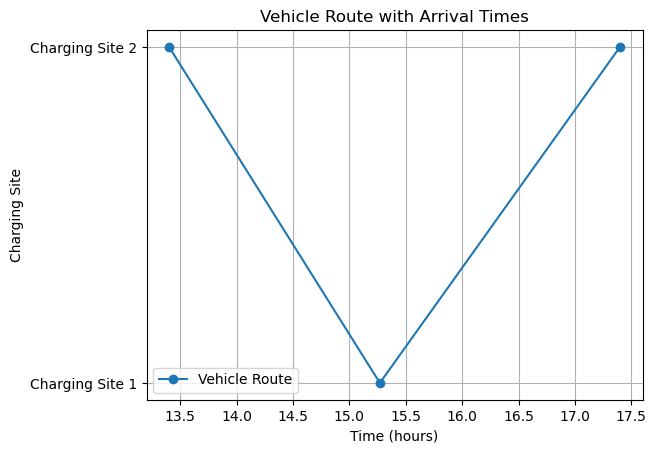

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
CHARGING_HUB_CAPACITY = 2 * 500  # kW
OPERATIONAL_COST_DAY = 3.50  # NOK per km
OPERATIONAL_COST_NIGHT_WEEKEND = 5.25  # NOK per km
EXCAVATOR_BATTERY_CAPACITY = 250  # kWh
EXCAVATOR_SOC_MIN = 0.15
EXCAVATOR_SOC_MAX_DAY = 0.90
EXCAVATOR_SOC_MAX = 1.00
CHARGING_RATE_HIGH = 170  # kW
CHARGING_RATE_LOW = 50  # kW
CHARGING_SITE_1_DISTANCE = 8  # km
CHARGING_SITE_2_DISTANCE = 12  # km
CHARGING_SITE_BATTERY_CAPACITY = 550  # kWh
TRANSPORT_ENERGY = 550  # kWh
OPERATION_TIME_START = 7.0  # 7:00 AM
OPERATION_TIME_END = 19.0  # 7:00 PM
VEHICLE_SPEED = 30  # km/h
SERVICE_TIME = 0.5  # hours

# Excavator consumption rates (kWh/h)
EXCAVATOR_CONSUMPTION = {
    1: 40,
    2: 50,
    3: 60,
    4: 70
}

# Define State class with float SOC
class State:
    def __init__(self, soc, time, energy, recharge_log=None, site_battery1_soc=1.00, site_battery2_soc=1.00, total_distance_day=0, total_distance_night=0):
        self.soc = soc  # SOC levels for each excavator
        self.time = time  # Current time
        self.energy = energy  # Available energy in transport units
        self.site_battery1_soc = site_battery1_soc  # SOC for charging site battery 1
        self.site_battery2_soc = site_battery2_soc  # SOC for charging site battery 2
        self.total_distance_day = total_distance_day  # Total distance traveled by the vehicle during the day
        self.total_distance_night = total_distance_night  # Total distance traveled by the vehicle during the night
        self.recharge_log = recharge_log if recharge_log is not None else []

    def __repr__(self):
        return f"State(SOC={self.soc}, Time={self.time:.2f}, Energy={self.energy}, SiteBattery1SOC={self.site_battery1_soc}, SiteBattery2SOC={self.site_battery2_soc}, TotalDistanceDay={self.total_distance_day}, TotalDistanceNight={self.total_distance_night}, RechargeLog={self.recharge_log})"

def update_soc(current_soc, charging_decisions, consumption_rates, time_interval, current_time, recharge_log):
    new_soc = []
    for i in range(4):
        soc = current_soc[i]
        charging_decision = charging_decisions[i]
        consumption = consumption_rates[i] * time_interval
        
        # SOC degradation
        new_soc_value = soc - (consumption / EXCAVATOR_BATTERY_CAPACITY)
        
        # Charging logic
        if soc <= EXCAVATOR_SOC_MIN and soc < EXCAVATOR_SOC_MAX_DAY:
            new_soc_value += (charging_decision * time_interval / EXCAVATOR_BATTERY_CAPACITY)
        
        new_soc_value = min(max(new_soc_value, 0), EXCAVATOR_SOC_MAX)
        
        # charging time saved in log
        if soc <= EXCAVATOR_SOC_MIN and new_soc_value > soc and charging_decision > 0:
            recharge_log.append(f"Excavator {i+1} starts charging at hour {current_time:.2f}") 
        if soc < EXCAVATOR_SOC_MAX_DAY and new_soc_value >= EXCAVATOR_SOC_MAX_DAY:
            recharge_log.append(f"Excavator {i+1} stops charging at hour {current_time:.2f}")
        
        new_soc.append(new_soc_value)
    
    return new_soc, recharge_log

def update_energy(current_energy, transport_decision, charging_decisions):
    # Transport energy consumption
    transport_energy_consumption = 0
    if transport_decision > 0:
        transport_energy_consumption = CHARGING_SITE_1_DISTANCE if transport_decision == 1 else CHARGING_SITE_2_DISTANCE

    # Charging energy consumption
    charging_energy_consumption = sum(charging_decisions) * 1  # Total kWh for 1 hour

    # Calculate the new energy level
    new_energy = current_energy - transport_energy_consumption - charging_energy_consumption
    return new_energy

def update_site_battery_soc(site_battery_soc, charging_energy_consumption, time_interval):
    site_battery_soc -= charging_energy_consumption / CHARGING_SITE_BATTERY_CAPACITY
    return max(site_battery_soc, 0)

def calculate_cost(total_distance_day, total_distance_night):
    day_cost = total_distance_day * OPERATIONAL_COST_DAY
    night_cost = total_distance_night * OPERATIONAL_COST_NIGHT_WEEKEND
    return day_cost + night_cost

def calculate_transport_time(distance, speed):
    """Calculate the transport time based on distance and speed."""
    return distance / speed

# Initialize DP table with float SOC using a dictionary for sparse representation
dp = {}

# Initial state with SOC = 1.00 (100%) for all excavators
initial_soc = [1.00] * 4
initial_state = State(initial_soc, OPERATION_TIME_START, TRANSPORT_ENERGY)
dp[(tuple(initial_soc), OPERATION_TIME_START, TRANSPORT_ENERGY, 1.00, 1.00)] = (0, initial_state)

# Recurrence relation with float SOC levels
time_steps = np.arange(OPERATION_TIME_START, OPERATION_TIME_END + 1, 1.0)  # Use 1-hour steps for simplicity

for time in time_steps:
    new_dp = {}
    for (soc, current_time, energy, site_battery1_soc, site_battery2_soc), (cost, state) in dp.items():
        current_state = State(list(soc), current_time, energy, state.recharge_log.copy(), site_battery1_soc, site_battery2_soc, state.total_distance_day, state.total_distance_night)
        
        # Charging decisions
        charging_decisions = [
            CHARGING_RATE_HIGH if soc[0] <= EXCAVATOR_SOC_MIN and soc[0] < EXCAVATOR_SOC_MAX_DAY else 0,
            CHARGING_RATE_HIGH if soc[1] <= EXCAVATOR_SOC_MIN and soc[1] < EXCAVATOR_SOC_MAX_DAY else 0,
            CHARGING_RATE_HIGH if soc[2] <= EXCAVATOR_SOC_MIN and soc[2] < EXCAVATOR_SOC_MAX_DAY else 0,
            CHARGING_RATE_HIGH if soc[3] <= EXCAVATOR_SOC_MIN and soc[3] < EXCAVATOR_SOC_MAX_DAY else 0
        ]
        
        # Consumption rates
        consumption_rates = [
            EXCAVATOR_CONSUMPTION[1],
            EXCAVATOR_CONSUMPTION[2],
            EXCAVATOR_CONSUMPTION[3],
            EXCAVATOR_CONSUMPTION[4]
        ]
        
        new_soc, updated_log = update_soc(current_state.soc, charging_decisions, consumption_rates, 1, time, current_state.recharge_log)
        new_energy = update_energy(current_state.energy, 1, charging_decisions)  # Example transport decision

        # Update site battery SOCs
        site1_charging_energy = charging_decisions[0] + charging_decisions[1]
        site2_charging_energy = charging_decisions[2] + charging_decisions[3]
        new_site_battery1_soc = update_site_battery_soc(current_state.site_battery1_soc, site1_charging_energy, 1)
        new_site_battery2_soc = update_site_battery_soc(current_state.site_battery2_soc, site2_charging_energy, 1)

        # Check for battery replacement for site 1
        if new_site_battery1_soc <= EXCAVATOR_SOC_MIN:
            replacement_time = calculate_transport_time(CHARGING_SITE_1_DISTANCE, VEHICLE_SPEED)
            arrival_time = time + replacement_time
            new_site_battery1_soc = 1.00
            if time < 18.0:
                current_state.total_distance_day += 2 * CHARGING_SITE_1_DISTANCE
            else:
                current_state.total_distance_night += 2 * CHARGING_SITE_1_DISTANCE
            updated_log.append(f"Vehicle arrives at Charging site 1 at hour {arrival_time:.2f}")
            updated_log.append(f"Charging site battery 1 replaced at hour {arrival_time + SERVICE_TIME:.2f}")

        # Check for battery replacement for site 2
        if new_site_battery2_soc <= EXCAVATOR_SOC_MIN:
            replacement_time = calculate_transport_time(CHARGING_SITE_2_DISTANCE, VEHICLE_SPEED)
            arrival_time = time + replacement_time
            new_site_battery2_soc = 1.00
            if time < 18.0:
                current_state.total_distance_day += 2 * CHARGING_SITE_2_DISTANCE
            else:
                current_state.total_distance_night += 2 * CHARGING_SITE_2_DISTANCE
            updated_log.append(f"Vehicle arrives at Charging site 2 at hour {arrival_time:.2f}")
            updated_log.append(f"Charging site battery 2 replaced at hour {arrival_time + SERVICE_TIME:.2f}")

        new_cost = calculate_cost(current_state.total_distance_day, current_state.total_distance_night)

        new_state = State(new_soc, time, new_energy, updated_log, new_site_battery1_soc, new_site_battery2_soc, current_state.total_distance_day, current_state.total_distance_night)

        new_dp[(tuple(new_soc), time, new_energy, new_site_battery1_soc, new_site_battery2_soc)] = (new_cost, new_state)
    
    dp = new_dp

# Find the minimum cost in the final state
final_costs = [(cost, state) for (soc, time, energy, site_battery1_soc, site_battery2_soc), (cost, state) in dp.items() if time == OPERATION_TIME_END]
min_cost, final_state = min(final_costs, key=lambda x: x[0])

# Output the minimum cost
print(f"Minimum Operational Cost: {min_cost} NOK")

# Output the total travel distance
total_distance_day = final_state.total_distance_day
total_distance_night = final_state.total_distance_night
print(f"Total travel distance during the day: {total_distance_day} km")
print(f"Total travel distance during the night: {total_distance_night} km")
print(f"Total travel distance: {total_distance_day + total_distance_night} km")

# Output the recharge logs
print("Recharge logs:")
for log in final_state.recharge_log:
    print(log)

# Visualization
# Extract arrival times and sites for visualization
arrival_times = []
sites = []

for log in final_state.recharge_log:
    if "arrives at Charging site" in log:
        time_str = log.split("at hour ")[1]
        time = float(time_str)
        site = 1 if "site 1" in log else 2
        arrival_times.append(time)
        sites.append(site)

# Plot the vehicle route
fig, ax = plt.subplots()
ax.plot(arrival_times, sites, marker='o', linestyle='-', label='Vehicle Route')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Charging Site')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Charging Site 1', 'Charging Site 2'])
ax.set_title('Vehicle Route with Arrival Times')
ax.legend()
plt.grid(True)
plt.show()
